In [1]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt
import ipywidgets as widgets 
from enum import Enum
from IPython.display import display

## TO DO 
"""
- Fix horizontal plots 
- Fix the parameter sliders
- button to change what control function the user can choose? 
- Implement vector plots


"""


'\n\n- Fix horizontal plots \n- Fix the parameter sliders\n- button to change what control function the user can choose? \n- Implement vector plots\n\n\n'

In [77]:
# Excitation and inhibition dictionaries

excite = {
  'komarova': lambda pop, k: f'{pop}/{k}',
  'lander':   lambda pop, a: f'{pop}/(1+{a}*{pop})',
  'hill':     lambda pop, a, n=4: f'({pop}^{n})/(1+({a}*{pop})^{n})',
}

inhib = {
  'komarova': lambda pop, k: f'1-({pop}/{k})',
  'lander':   lambda pop, a: f'1/(1+{a}*{pop})',
  'hill':     lambda pop, a, n=4: f'1/(1+({a}*{pop})^{n})',
}



### Introduction

Tissues typically denote heterogeneous cell collectives that often exhibit complex and interesting behavior that would otherwise not be seen in single cells alone. In the most generic form, we can understand tissues as being composed of three major types of cells, those being: stem cells, transit-amplifying cells, and differentiated cells. Additionally, we know that these cell types can secrete regulatory factors that can exhibit control factors on the other cell populations. These factors can be understood to have positive or negative effects. Recent work in mathematical biology has outlined multiple cell lineage control topologies that result in local tissue homeostasis. In this application, we replicate and extend this work in order to investigate the qualitative dynamics that can be observed in these topologies. In the literature, there have been several different mathematical forms of control functions. In our implementation of the two and three-stage models, we examine the similarities and differences between the different forms of control that can be implemented. Furthermore, many of the qualitative aspects of the models have previously gone unaddressed. Using dynamical systems theory, we highlight many of the qualitative characteristics seen in these models and report on homologous or degenerate solutions.

In [7]:
# Defining two stage model generator. 

def twoCompartmentModel(STEM='1', DIFF='0',
                        L='0.5', P='0.5', D='0.1',
                        Control=['1','1','1'], Events=[]):

    if (float(L)>1 or float(P)>1 or float(D)>1):
        raise ValueError('L, P, and D must be less than or equal to 1.')


    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    DIFF = {DIFF};

    # Parameters 
    L = {L}; P = {P}; D = {D};
    
    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_D:  STEM -> DIFF; P * 2 * L * STEM * ({Control[1]});

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; D * DIFF * ({Control[2]});

    #Events 
    {eventString}
    """

## A Two-Stage network without control: 

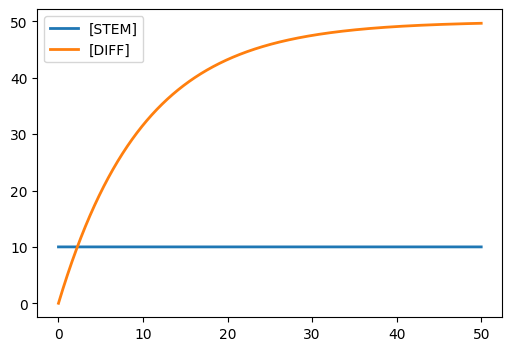

In [98]:
NoControl = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=['1', '1', '1'], 
  Events=[])
r = te.loada(NoControl)
s = r.simulate(0, 50, 10000) 
r.plot(s)

## 2 Two-Stage networks with control: 

![](../tellurium-nanohub-base/assets/inhib_inhib.png)

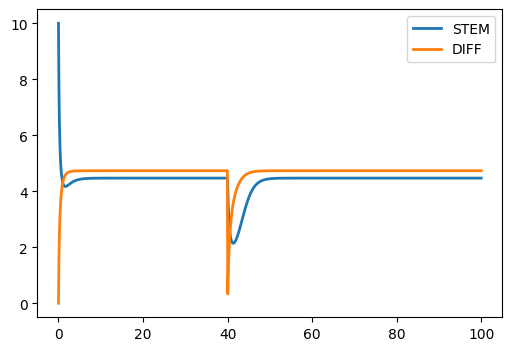

In [101]:
DoubleInhib = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('DIFF','5'), '1'], 
  Events=['at time > 40: DIFF = 0;'])


r = te.loada(DoubleInhib)
s = r.simulate(0, 100, 1000, ['time', 'STEM', 'DIFF']) #','ES_2S','ES_D','ED_D'])
r.plot(s)


![](../tellurium-nanohub-base/assets/excite_inhib.png)

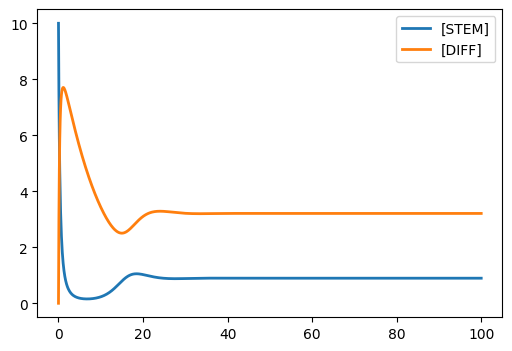

In [102]:
InhibExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('DIFF','5'), excite['komarova']('STEM','5'), '1'], 
  Events=[])
r = te.loada(InhibExcite)
s = r.simulate(0, 100, 1000)
r.plot(s)


### A two stage model where death rate is not a constant:

The following system excites stem cell division rate while also exciting the death rate of terminally differentiated cells. While this model does exhibit homeostasis, it is incredibly fragile to perturbations. Below, we can see that even a minor hit to the population of differentiated cells will kill off the entire population of stem cells 10 steps later. 

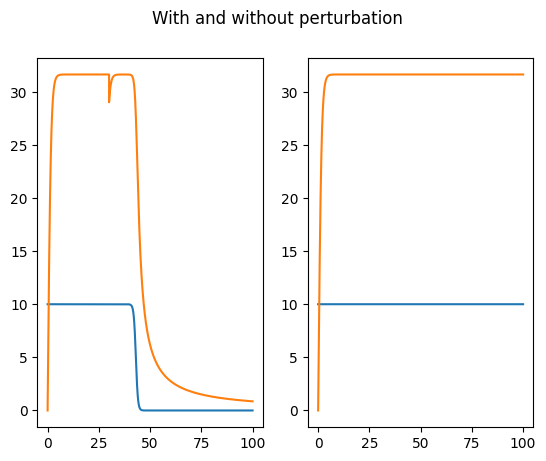

In [103]:
ExciteExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[excite["komarova"]('STEM', 5), '1', excite["komarova"]('DIFF', 5)], 
  Events=['at time > 30: DIFF = 29;'])
ExciteExcite2 = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[excite["komarova"]('STEM', 5), '1', excite["komarova"]('DIFF', 5)], 
  Events=[])

r = te.loada(ExciteExcite)
r2 = te.loada(ExciteExcite2)
s = r.simulate(0, 100, 10000, ['STEM', 'DIFF'])
s2 = r2.simulate(0, 100, 10000, ['STEM', 'DIFF'])
#r.plot(s)
time = np.arange(0, 100, 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('With and without perturbation')
ax1.plot(time, s)
ax2.plot(time, s2)

### This one is iteresting because it survives, is robust to perturbations, and was not reported as being stable in the literature. 

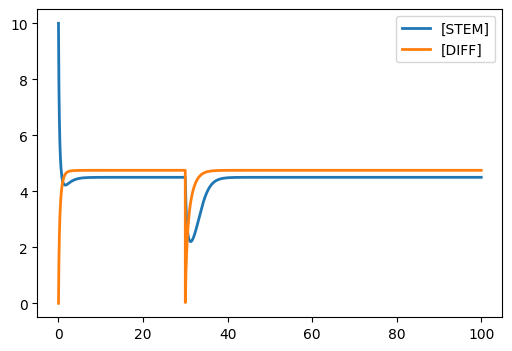

In [104]:
InhibInhibExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib["komarova"]('STEM', 5), inhib["komarova"]('DIFF', 5), excite["komarova"]('DIFF', 5)], 
  Events=['at time > 30: DIFF = 0;'])
r = te.loada(InhibInhibExcite)
s = r.simulate(0, 100, 10000)
r.plot(s)

### Different forms of control: 

We can now examine the relationship between the multiple different types of control found in the literature in our two-stage system.

First, the original method of control used by Komarova (2013):

**Excitation:** $\frac{CELL \ POP}{k}$
**Inhibition:** $ 1 - \frac{CELL\ POP}{k}$

Where CELL POP denotes the population of the cell stage that is doing the controlling, and k is a parameter. 

In their work in the olfactory epithelium, Lander et al. (2009), they use a variation on the tradiational hill function, where the population gets muliplied by the parameter alpha. 

**Excitation:** $\frac{CELL \ POP}{(1+\alpha(CELL \ POP))}$
**Inhibition:** $\frac{1}{(1+\alpha(CELL \ POP))}$

Lastly, we include a generalized Hill function, where n is an exponential parameter, typically set to either values of 4 or 8. 

**Excitation:** $\frac{CELL \ POP^n}{(1+\alpha(CELL \ POP))^n}$
**Inhibition:** $\frac{1^n}{(1+\alpha(CELL \ POP))^n}$

### Demonstating how the different types of control affect the system.

In [ ]:

@widgets.interact(
    STEM=widgets.FloatSlider(min=0, max=100, step=1, value=10, description='Stem Cells'),
    DIFF=widgets.FloatSlider(min=0, max=100, step=1, value=0, description='Differentiated Cells'),
    L=widgets.FloatSlider(min=0,max=10,step=0.01,value=0.5,description='Division Rate'),
    P=widgets.FloatSlider(min=0, max=10,step=0.01,value=0.5,description='Probability of Differentiation'),
    d=widgets.FloatSlider(min=0,max=10,step=0.01,value=0.1,description='Death Rate'),
    selection=widgets.Dropdown(options=['Without Control','Division inhibition and differentiation excitation','Division inhibition and differentiation inhibition'],description="Control Type"),
    duration=widgets.IntSlider(min=0, max=1000, step=1, value=100, description='End Date:'))               
def model_with_options(STEM,DIFF,L,P,d,selection,duration):
    if selection == NoControl:
        m = te.loada(NoControl)
        m.STEM = STEM
        m.DIFF = DIFF
        m.L = L
        m.P = P
        m.D = d
        s = m.simulate(0, duration, 1000)
        m.plot(s)
    elif selection == InhibExcite:
        m = te.loada(InhibExcite)
        m.STEM = STEM
        m.DIFF = DIFF
        m.L = L
        m.P = P
        m.D = d
        s = m.simulate(0, duration, 10000)
        m.plot(s)
    elif selection == DoubleInhib:
        m = te.loada(DoubleInhib)
        m.STEM = STEM
        m.DIFF = DIFF
        m.L = L
        m.P = P
        m.D = d
        s = m.simulate(0, duration, 10000)
        m.plot(s)
    else:
        print("Error") 

### Simple dynamical analysis of the two stage system

### Introduction to the three stage system: 

In [3]:
def threeCompartmentModel(STEM='1', INTER='0', DIFF='0',
                        L_S='0.5', P_S='0.5', 
                        L_I='0.5', P_I='0.5',
                        D='0.1',
                        Control=['1','1','1','1','1'], Events=[]):

    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    INTER = {INTER};
    DIFF = {DIFF};

    # Parameters
    L_S = {L_S}; P_S = {P_S}; L_I = {L_I}; P_I = {P_I}; DEATH = {D};

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L_S * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; P_S * 2 * L_S * STEM * ({Control[1]});

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; L_I * STEM * ({Control[2]});

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; P_I * 2 * L_I * STEM * ({Control[3]});

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; DEATH * DIFF * ({Control[4]});

    #Events
    {eventString}
    """

In [4]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=[])

r = te.loada(model)
print(te.getODEsFromModel(r))
# r.simulate(0, 1000, 10000)
# r.plot()
# print(model)



vES_2S = L_S*STEM*(1-STEM/5)
vES_I = P_S*2*L_S*STEM*(1-INTER/5)
vEI_2I = L_I*STEM*(1-DIFF/5)
vES_D = P_I*2*L_I*STEM*1
vED_D = DEATH*DIFF*1

dSTEM/dt = vES_2S - vES_I
dINTER/dt = vES_I + vEI_2I - vES_D
dDIFF/dt = vES_D - vED_D



In [106]:
def getMathematicaODEs(r):
  str = te.getODEsFromModel(r)
  strList = str.split('\n')[1:-1]
  rateDict = {}
  outStr = ''
  # print(strList)
  ratesflag = False

  for i in strList:
    if i == '':
      ratesflag = True
    elif not ratesflag:
      k, v = i.split(' = ')
      rateDict[k] = v
    else:
      str = ''
      for j in i.split(' '):
        if j in rateDict:
          str += rateDict[j]
        else:
          str += j
      outStr += f'{str}\n'
  return outStr

The three stage cell lineage is similar to our previous model, but with the addition of a transit-amplifying cell. These cells are XXX [Information about transit amplifiers and the reason that they are to be included]. 

More than a step above our two stage system, the three stage system produces 20 topologies capable of producing tissue homeostasis. Although, it has been shown that that only 2 of these result in biologically realistic tissue homeostasis (CITE ...Axelrod).



Additionally, the 20 different topologies all have a constant death rate. There are some cases where this is not the case. For example, ... . This added nuance has been captured in the expansion of the model by axelrod ... (CITE). This added factor produced 12 additional models on top of the initial 20, but only 1 of which is biologically realistic.

#### [Instead of going through the same process of with or without control, we can just show the 20 different topologies and then show the 2 that are biologically realistic. We will also expand the the model to include a new form of control loop that we see in the axelrod and komarova paper.]

Topology #1

![](../tellurium-nanohub-base/assets/Topology_1.png)

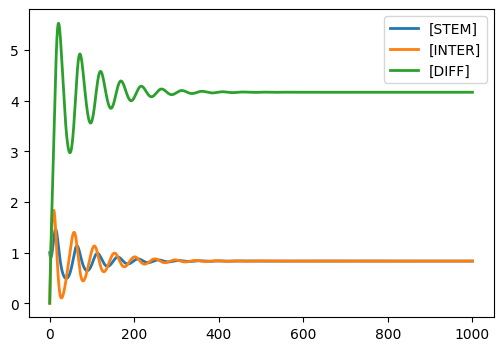


    # Initialized Populations
    STEM = 1;
    INTER = 0;
    DIFF = 0;

    # Parameters
    L_S = 0.5; P_S = 0.5; L_I = 0.5; P_I = 0.5; DEATH = 0.1;

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L_S * STEM * (1-(STEM/5));

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; P_S * 2 * L_S * STEM * (1-(INTER/5));

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; L_I * STEM * (1-(DIFF/5));

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; P_I * 2 * L_I * STEM * (1);

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; DEATH * DIFF * (1);

    #Events
    
    


In [5]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=[])

r = te.loada(model)
r.simulate(0, 1000, 10000)
r.plot()
print(model)


In [6]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','10'), inhib['komarova']('INTER','10'), inhib['komarova']('DIFF','10'), '1','1'],
  Events=[
  ])

## Flow Diagrams

In [87]:
# PLOT FLOW DIAGRAMS
def plotFlow(modelStr: str,      # Antimony model string
                    max: float = 10, # max initial value
                    ):
  steps = 16 # number of steps between 0 and max
  nCurves = steps*1j # the number of curves that you want to plot
  n = np.arange(steps) # number to iterate over in for loops

  increments = np.mgrid[0:max:nCurves] # an array of all initial values

  U, V = np.mgrid[0:max:nCurves, 0:max:nCurves] # two n x n arrays to store population values at time t+1

  r = te.loada(modelStr) # load the model

  ogVals = {'STEM': r.STEM, 'INTER': r.INTER, 'DIFF': r.DIFF} # store the original initial population values of the model

  cellTypes = ['STEM', 'INTER', 'DIFF'] # list of cell types

  # Create 3 subplots that are horizontally stacked
  _, ax = plt.subplots(1, 3, sharey=False, figsize=(20, 5), dpi=128)

  # Iterate over each cell type
  for i in np.arange(3):
    cellA = cellTypes[i]        # the cell type plotted on the x-axis
    cellB = cellTypes[(i+1)%3]  # the cell type plotted on the y-axis
    cellX = cellTypes[(i-1)%3]  # the cell type that is not plotted

    r[cellX] = ogVals[cellX]    # set the cell type that is not plotted to its original value

    # iterate over the x-axis
    for x in n:
      r[cellA] = increments[x]    # set the initial value of the x-axis cell type

      # iterate over the y-axis
      for y in n:
        r[cellB] = increments[y]  # set the initial value of the y-axis cell type

        U[y,x] = r[f"{cellA}'"]   # store the value of the x-axis cell type at time t+1
        V[y,x] = r[f"{cellB}'"]   # store the value of the y-axis cell type at time t+1

    ax[i].set_xlabel(cellA, fontsize='12')
    ax[i].set_ylabel(cellB, fontsize='12')

    ax[i].streamplot(increments,increments,U, V, density=[2, 2]) # Plot the Flow

  plt.show()  

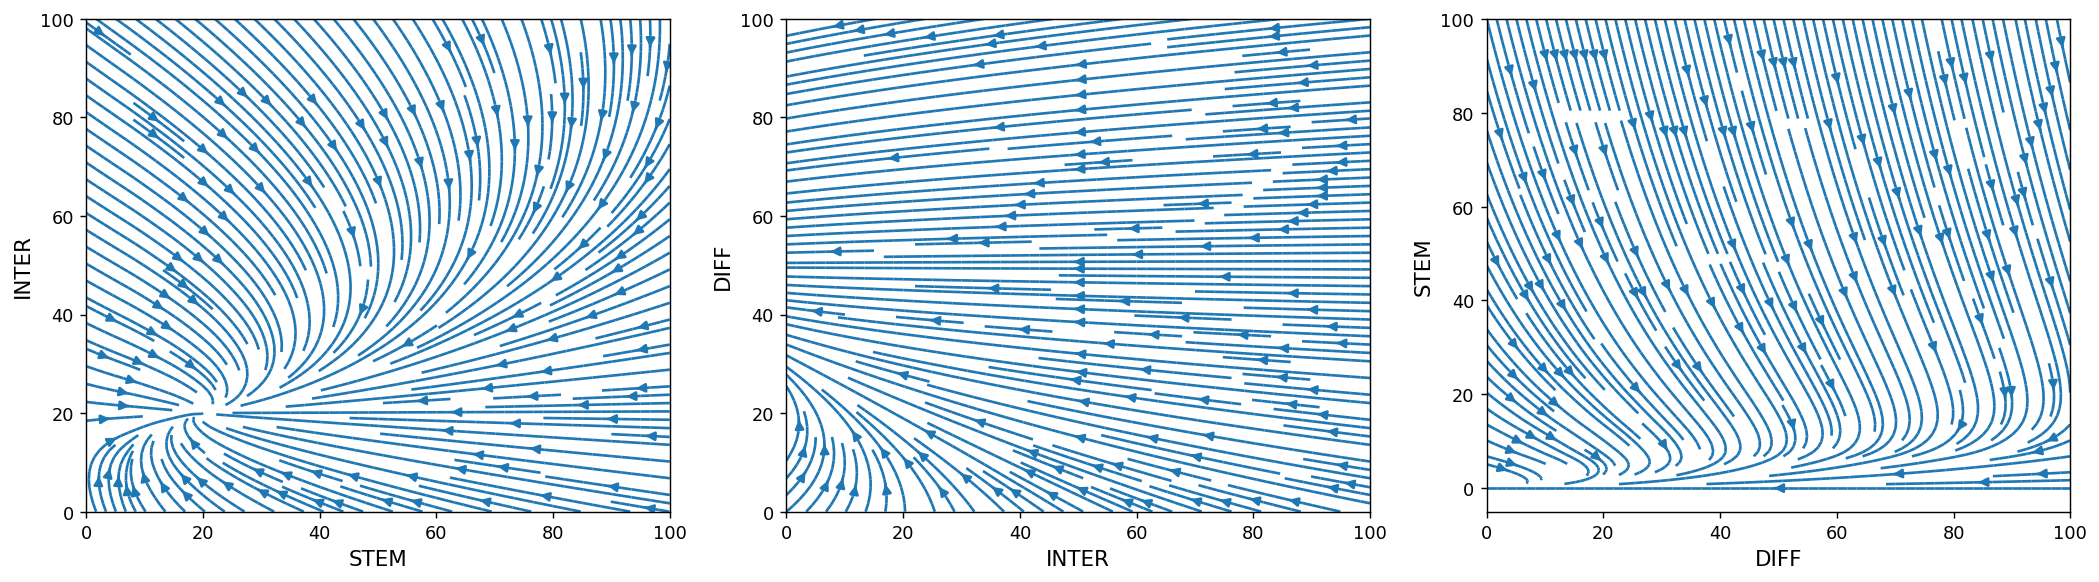

In [88]:
# FLOW PLOTS FOR THE ABOVE SYSTEM
# TODO: create an array of all 3 compartment model control systems and then run them all to see flows

model = threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','20'), inhib['komarova']('INTER','20'), inhib['komarova']('DIFF','20'), '1','1'],
  Events=[
  ])
# r = te.loada(model)
# r.simulate(0, 1000, 10000)
# r.plot()
# print(getMathematicaODEs(r))
plotFlow(model, max=100)

In [98]:
def plotFlow3Compartment(STEM, INTER, DIFF,L_S,P_S,L_I,P_I,D,controlType,controlParam):
  # controlType='komarova'
  model = threeCompartmentModel(
    STEM, INTER, DIFF, 
    L_S,P_S,
    L_I,P_I,
    D,
    Control=[inhib[controlType]('STEM',str(controlParam)), inhib[controlType]('INTER',str(controlParam)), inhib[controlType]('DIFF',str(controlParam)), '1','1'],
    Events=[])
  plotFlow(model, max=100)

In [97]:
def labelBox(label, widget):
    return widgets.VBox(
        children=[
            widgets.Label(value=label),
            widget
        ]
    )

STEM=widgets.FloatSlider(min=0, max=100, step=1, value=10, continuous_update=False)
INTER=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
DIFF=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
box1 = widgets.HBox(
    [labelBox('Stem',STEM),
    labelBox('TAC',INTER),
    labelBox('Differentiated',DIFF)], 
    description='Initial Values')

L_S=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
L_I=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
box2 = widgets.HBox([
    labelBox('Stem',L_S),
    labelBox('TAC',L_I)])

P_S=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
P_I=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
box3 = widgets.HBox([
    labelBox('Stem → TAC',P_S),
    labelBox('TAC → Differentiated',P_I)])

D=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1, continuous_update=False)

ControlType = widgets.ToggleButtons(
    options=['komarova', 'lander', 'hill'],
    disabled=False,
    button_style='',
    tooltips=['pop/k', 'pop/(1+a*pop)', 'pop^n/(1+a*pop^n)'],
)

controlParam=widgets.FloatSlider(min=0, max=200, step=0.1, value=20, continuous_update=False)

inputs = widgets.VBox([
    widgets.HTML('<font size="+1">Initial Populations</font>'),box1,
    widgets.HTML('<font size="+1">Division Rates</font>'), box2,
    widgets.HTML('<font size="+1">Differentiation Probability</font>'), box3,
    widgets.HTML('<font size="+1">Death Rate</font>'), D,
    widgets.HTML('<font size="+1">Control Mechanism</font>'), ControlType,
    widgets.HTML('<font size="+1">Control Parameter</font>'), controlParam
    ])

out = widgets.interactive_output(plotFlow3Compartment, {
    'STEM': STEM, 'INTER': INTER, 'DIFF': DIFF,
    'L_S':L_S,'P_S':P_S,
    'L_I':L_I,'P_I':P_I,
    'D':D,
    'controlType':ControlType,
    'controlParam':controlParam})

display(inputs,out)

Output()

Topology #2

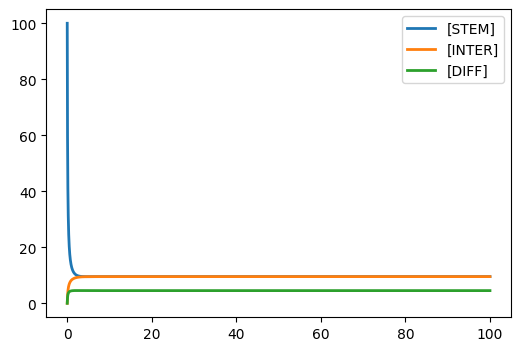

In [112]:
model = threeCompartmentModel(
  STEM='100', INTER='0', DIFF='0', 
  L_S='0.5',P_S='.5',L_I='.5',P_I='.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', inhib['komarova']('DIFF','5'),'1'],
  Events=[])

r = te.loada(model)
r.simulate(0, 100, 10000)
r.plot()

### Axelrod and Komarova's Topology: 

![](../tellurium-nanohub-base/assets/AxelrodTopo.png)

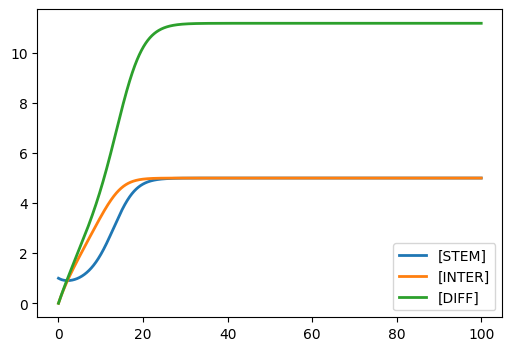

In [54]:
model = threeCompartmentModel(
 STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', '1', excite['komarova']('DIFF','5')],
  Events=[])

r = te.loada(model)
r.simulate(0, 100, 10000)
r.plot()

### Dynamical Analysis of the three stage system:

### Perturbation analysis

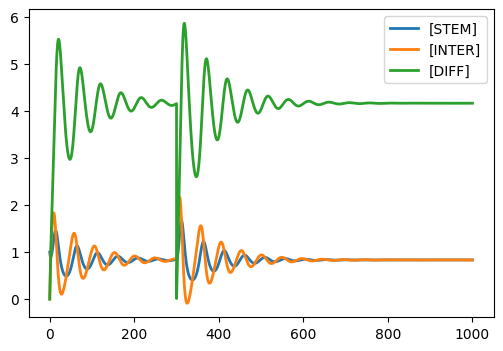

In [55]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=[
    'at (time > 300): DIFF = 0'
  ])

r = te.loada(model)
r.simulate(0, 1000, 10000)
r.plot()



One of the markers of a biologically realistic circuit is one that exhibits oscillatory recovery. [expand and cite the studies that the axelrod paper mentions]

In [56]:

class Params(Enum):
  # two compartments
  L = 'L'
  P = 'P'
  D = 'D'
  # three compartments
  L_S = 'L_S'
  L_I = 'L_I'
  P_S = 'P_S'
  P_I = 'P_I'  
  
  STEM = 'STEM'
  INTER = 'INTER'
  DIFF = 'DIFF'
    
# First version
def printHighLowBifurcationScan(modelStr: str,
                                scanningParam: Params = Params.L_S,                                
                                highLow: Params = Params.STEM,
                                range: np.array = np.arange(0, 2, 0.01),                                
                                lowInit: float = 0.1,
                                highInit: float = 20.0,
                                simulateLen: int = 1000,
                                titleAppend: str = ''):
  try:
    r = te.loada(modelStr)
    results = np.empty([0,3])
    for param in range:
      r.resetAll()

      r[highLow.value] = lowInit      
      r[scanningParam.value] = param
      m = r.simulate(0, simulateLen, 1000)
      lowEnding = r[highLow.value]
      r.resetAll()

      r[highLow.value] = highInit
      r[scanningParam.value] = param      
      m = r.simulate(0, simulateLen, 1000)
      highEnding = r[highLow.value]

      newRow = [param, lowEnding, highEnding]
      results = np.vstack([ results, newRow ])
    te.plotArray(results,
                title="{} Bifurcation Scan {}".format(titleAppend, scanningParam), 
                resetColorCycle=False, 
                labels=[ "{}_low".format(highLow.value), "{}_high".format(highLow.value) ])
  except RuntimeError:
    print('{} hit error'.format(titleAppend))


In [57]:
modeltest = ('''
   
    # Initialized Populations
    STEM = 1;
    INTER = 0;
    DIFF = 0;

    # Parameters
    L_S = 0.5;
    P_S = 0.5;
    L_I = 0.5;
    P_I = 0.5;
    D = 0.1;
    
    # DIVISION RATE OF STEM CELLS
    L_S = 0.5;

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L_S * STEM * (1-(STEM/5));

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; P_S * 2 * 0.5 * STEM * (1-(INTER/5));

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; L_I * STEM * (1-(DIFF/5));

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; P_I * 2 * 0.5 * STEM * (1);

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; D * DIFF * (1);

    ''')

# model = threeCompartmentModel(
#   STEM='1', INTER='0', DIFF='0', 
#   LS='0.5',PS='0.5',LI='0.5',PI='0.5',D='0.1',
#   Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
#   Events=[])



In [58]:

# printHighLowBifurcationScan(modeltest, scanningParam=Params.LS, range= np.arange(0, 10, 0.01))
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_S)
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_I)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_S)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_I)

printHighLowBifurcationScan(modeltest, scanningParam=Params.L_S, highLow= Params.INTER)
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_I, highLow= Params.INTER)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_S, highLow= Params.INTER)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_I, highLow= Params.INTER)

printHighLowBifurcationScan(modeltest, scanningParam=Params.L_S, highLow= Params.DIFF)
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_I, highLow= Params.DIFF)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_S, highLow= Params.DIFF)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_I, highLow= Params.DIFF)


AttributeError: LS